In [1]:
!pip install -q shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


from sklearn.cluster import KMeans
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, confusion_matrix, roc_curve,
adjusted_rand_score, normalized_mutual_info_score, silhouette_score
)


import shap
np.random.seed(42)

In [2]:
#Breast Cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
class_names = ['Benign', 'Malignant']

In [3]:
#Veri Bölme (%70 / %10 / %20 – Stratified)

X_temp, X_test, y_temp, y_test = train_test_split(
X, y, test_size=0.20, stratify=y, random_state=42
)


X_train, X_val, y_train, y_val = train_test_split(
X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
)


print(X_train.shape, X_val.shape, X_test.shape)

(398, 30) (57, 30) (114, 30)


In [5]:
#3) Ortak Değerlendirme Fonksiyonu
def evaluate(model, X, y, average='binary'):
  y_pred = model.predict(X)
  y_proba = model.predict_proba(X)
  return {
  'Accuracy': accuracy_score(y, y_pred),
  'Precision': precision_score(y, y_pred, average=average),
  'Recall': recall_score(y, y_pred, average=average),
  'F1': f1_score(y, y_pred, average=average),
  'ROC-AUC': roc_auc_score(y, y_proba[:,1]) if average=='binary' else roc_auc_score(y, y_proba, multi_class='ovr')
  }

In [7]:
#4)KNN Sınıflandırma
#4.1 Baseline
knn_pipe = Pipeline([
('scaler', StandardScaler()),
('knn', KNeighborsClassifier(n_neighbors=5))
])


knn_pipe.fit(X_train, y_train)
knn_base_val = evaluate(knn_pipe, X_val, y_val)
knn_base_val

{'Accuracy': 0.9473684210526315,
 'Precision': 0.9230769230769231,
 'Recall': 1.0,
 'F1': 0.96,
 'ROC-AUC': np.float64(0.966931216931217)}

In [8]:
#4.2 Hiperparametre Optimizasyonu
param_knn = {
'knn__n_neighbors': list(range(1, 32, 2)),
'knn__weights': ['uniform', 'distance'],
'knn__p': [1, 2]
}


gs_knn = GridSearchCV(
knn_pipe, param_knn, scoring='f1', cv=5, n_jobs=-1
)


gs_knn.fit(X_train, y_train)


gs_knn.best_params_

{'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}

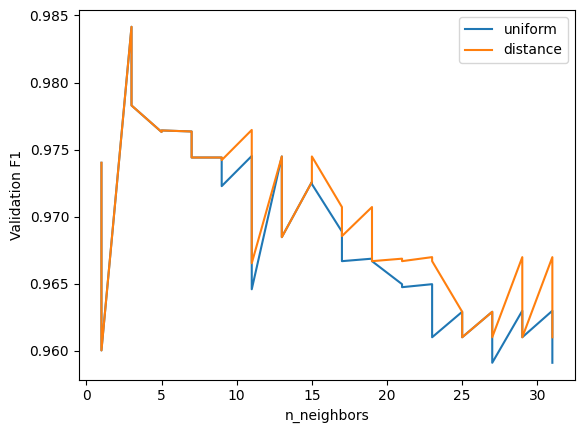

In [10]:
# 4.3 Zorunlu Grafik – k vs Validation F1
results = pd.DataFrame(gs_knn.cv_results_)


plt.figure()
for w in ['uniform', 'distance']:
    subset = results[results['param_knn__weights'] == w]
    plt.plot(subset['param_knn__n_neighbors'], subset['mean_test_score'], label=w)


plt.xlabel('n_neighbors')
plt.ylabel('Validation F1')
plt.legend()
plt.show()

In [11]:
#5) SVM Sınıflandırma
svm_pipe = Pipeline([
('scaler', StandardScaler()),
('svm', SVC(probability=True))
])


param_svm = [
{
'svm__kernel': ['linear'],
'svm__C': [0.01, 0.1, 1, 10, 100]
},
{
'svm__kernel': ['rbf'],
'svm__C': [0.01, 0.1, 1, 10, 100],
'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}
]


gs_svm = GridSearchCV(
svm_pipe, param_svm, scoring='f1', cv=5, n_jobs=-1
)


gs_svm.fit(X_train, y_train)


gs_svm.best_params_

{'svm__C': 0.1, 'svm__kernel': 'linear'}

In [12]:
#6) MLP Sınıflandırma
mlp_pipe = Pipeline([
('scaler', StandardScaler()),
('mlp', MLPClassifier(max_iter=500, random_state=42))
])


param_mlp = {
'mlp__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
'mlp__activation': ['relu', 'tanh'],
'mlp__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
'mlp__learning_rate_init': [0.001, 0.01],
'mlp__early_stopping': [True]
}


gs_mlp = GridSearchCV(
mlp_pipe, param_mlp, scoring='f1', cv=3, n_jobs=-1
)


gs_mlp.fit(X_train, y_train)


gs_mlp.best_params_

{'mlp__activation': 'relu',
 'mlp__alpha': 1e-05,
 'mlp__early_stopping': True,
 'mlp__hidden_layer_sizes': (50, 50),
 'mlp__learning_rate_init': 0.01}

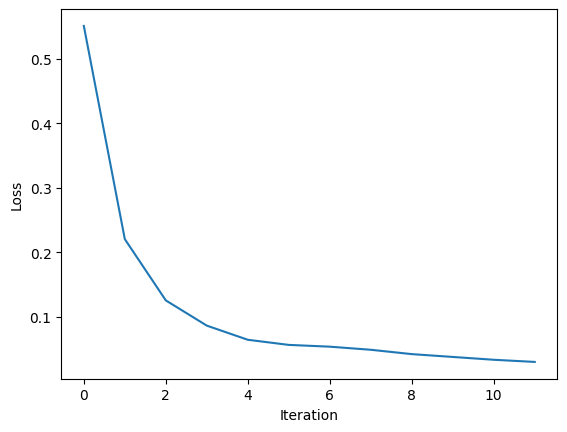

In [13]:
#6.1 Loss Curve
best_mlp = gs_mlp.best_estimator_
plt.figure()
plt.plot(best_mlp.named_steps['mlp'].loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [15]:
#7) Validation Karşılaştırma Tablosu
models = {
'KNN': gs_knn.best_estimator_,
'SVM': gs_svm.best_estimator_,
'MLP': gs_mlp.best_estimator_
}


rows = []
for name, model in models.items():
  scores = evaluate(model, X_val, y_val)
  scores['Model'] = name
  rows.append(scores)


val_table = pd.DataFrame(rows).set_index('Model')
val_table

,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
KNN,0.947368,0.945946,0.972222,0.958904,0.966931
SVM,0.964912,0.947368,1.000000,0.972973,0.992063
MLP,0.929825,0.900000,1.000000,0.947368,0.976190


In [16]:
#8) En İyi Model – Test Değerlendirmesi
best_model = gs_svm.best_estimator_ # örnek


test_scores = evaluate(best_model, X_test, y_test)
test_scores

{'Accuracy': 0.9736842105263158,
 'Precision': 0.9726027397260274,
 'Recall': 0.9861111111111112,
 'F1': 0.9793103448275862,
 'ROC-AUC': np.float64(0.9940476190476191)}

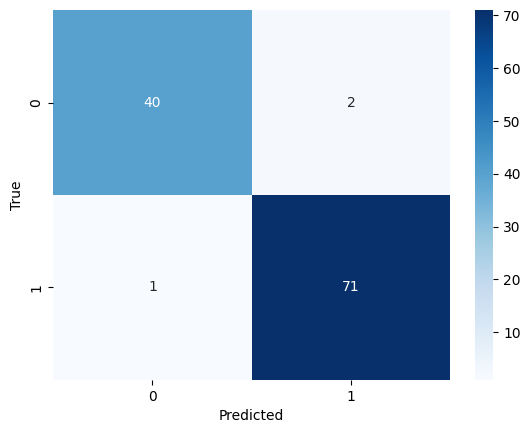

In [17]:
#8.1 Confusion Matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


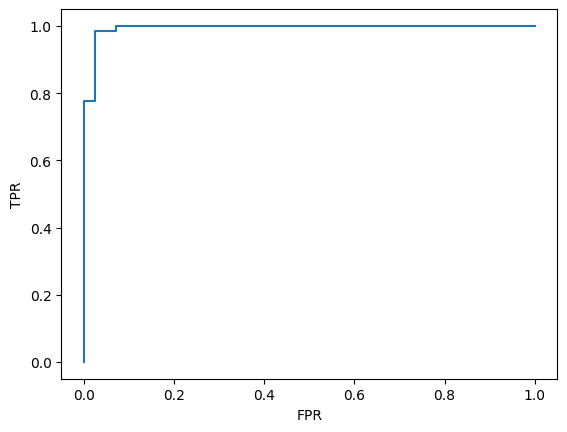

In [19]:
#8.2 ROC Curve
y_score = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thr = roc_curve(y_test, y_score)


plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

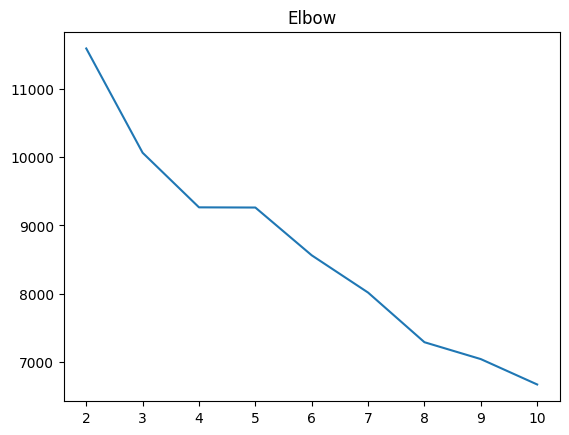

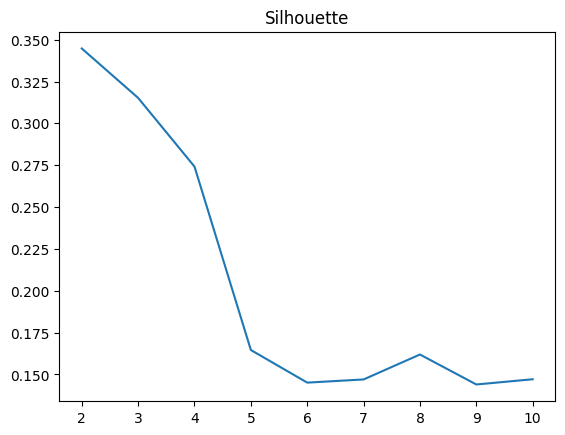

ARI: 0.676504895633523
NMI: 0.562020936206382


In [20]:
#9) KMeans Kümeleme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


inertias, silhouettes = [], []
for k in range(2, 11):
  km = KMeans(n_clusters=k, random_state=42)
  labels = km.fit_predict(X_scaled)
  inertias.append(km.inertia_)
  silhouettes.append(silhouette_score(X_scaled, labels))


plt.figure()
plt.plot(range(2,11), inertias)
plt.title('Elbow')
plt.show()


plt.figure()
plt.plot(range(2,11), silhouettes)
plt.title('Silhouette')
plt.show()
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)


print('ARI:', adjusted_rand_score(y, clusters))
print('NMI:', normalized_mutual_info_score(y, clusters))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  0%|          | 0/114 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

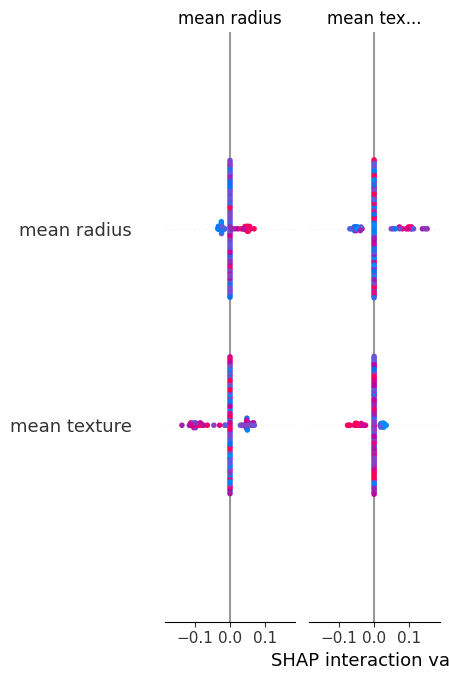

/tmp/ipython-input-1110247741.py:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


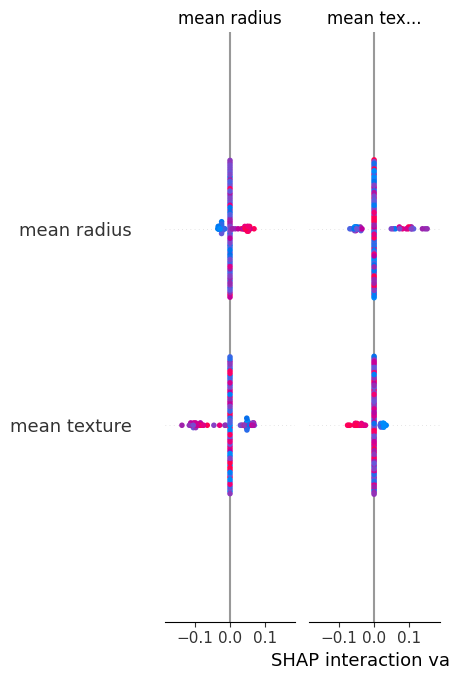

In [27]:
import shap
import numpy as np

def model_proba(X):
    return best_model.predict_proba(X)

# numpy array kullan (Pipeline + SHAP için en stabil yol)
X_train_np = X_train.values
X_test_np = X_test.values

background = shap.sample(X_train_np, 100, random_state=42)
X_shap = shap.sample(X_test_np, 200, random_state=42)

explainer = shap.KernelExplainer(model_proba, background)

shap_values = explainer.shap_values(X_shap)

# 🔴 KRİTİK KISIM
# Eğer shap_values list ise → class 1
# Değilse → direkt kullan
if isinstance(shap_values, list):
    shap_vals = shap_values[1]
else:
    shap_vals = shap_values

shap.summary_plot(
    shap_vals,
    X_shap,
    feature_names=X_train.columns
)

shap.summary_plot(
    shap_vals,
    X_shap,
    feature_names=X_train.columns,
    plot_type="bar"
)



